# Implementation of ConvNeXt: A ConvNet for the 2020s
# With Activation Function and Normalization Improvements

This notebook implements the ConvNeXt architecture as described in the paper "A ConvNet for the 2020s" by Liu et al. ConvNeXt is a pure convolutional neural network architecture designed to match or exceed the performance of Vision Transformers while maintaining the simplicity and efficiency of traditional ConvNets.

## Table of Contents

1. [Introduction](#1-introduction)
2. [Setup and Imports](#2-setup-and-imports)
3. [Architecture Implementation](#3-architecture-implementation)
4. [Dataset Preparation](#4-dataset-preparation)
5. [Training Setup](#5-training-setup)
6. [Model Training](#6-model-training)
7. [Model Evaluation](#7-model-evaluation)
8. [Performance Analysis](#8-performance-analysis)
9. [Conclusion and Next Steps](#9-conclusion-and-next-steps)

## 1. Introduction

The paper "A ConvNet for the 2020s" explores the design space of convolutional neural networks by gradually "modernizing" a standard ResNet toward the design of a vision Transformer. The authors discover several key components that contribute to the performance difference along the way, resulting in the ConvNeXt architecture.

Key innovations of ConvNeXt include:

- Replacing the traditional stem with a "patchify" layer (4×4 non-overlapping convolution)
- Using depthwise convolutions with larger kernel sizes (7×7)
- Adopting an inverted bottleneck design
- Reducing the number of activation functions and normalization layers
- Substituting BatchNorm with LayerNorm
- Adding separate downsampling layers between stages

These modifications allow ConvNeXt to achieve performance comparable to or better than Swin Transformers across various vision tasks while maintaining the simplicity of standard ConvNets.

# [ADDED] Improvements implemented in this notebook:
# 1. Activation Function Optimization: Testing alternatives to GELU
# 2. Normalization Strategy Improvements: Testing alternatives to LayerNorm
# The goal is to determine which combinations yield the best performance.

## 2. Setup and Imports

Let's start by installing and importing the necessary packages:

In [1]:
# Install packages (if needed)
# !pip install torch torchvision timm matplotlib numpy pandas seaborn tqdm ipywidgets

In [2]:
import os
import math
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from timm.models.layers import trunc_normal_, DropPath
from timm.data.transforms import RandomResizedCropAndInterpolation
from timm.data.mixup import Mixup
from timm.loss import LabelSmoothingCrossEntropy, SoftTargetCrossEntropy
from tqdm.notebook import tqdm
import pandas as pd  # [ADDED] For summary table

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

/home/horus/Workspace/miniconda3/envs/jupyter/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


Using device: cuda


## 3. Architecture Implementation

Now, let's implement the core components of the ConvNeXt architecture:

### 3.1 LayerNorm Implementation

The ConvNeXt architecture uses LayerNorm instead of BatchNorm, with support for both channels_last and channels_first formats:

In [3]:
class LayerNorm(nn.Module):
    """
    LayerNorm that supports two data formats: channels_last (default) or channels_first.
    channels_last = (batch_size, height, width, channels)
    channels_first = (batch_size, channels, height, width)
    """
    def __init__(self, normalized_shape, eps=1e-6, data_format="channels_last"):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(normalized_shape))
        self.bias = nn.Parameter(torch.zeros(normalized_shape))
        self.eps = eps
        self.data_format = data_format
        if self.data_format not in ["channels_last", "channels_first"]:
            raise NotImplementedError
        self.normalized_shape = (normalized_shape, )
    
    def forward(self, x):
        if self.data_format == "channels_last":
            return F.layer_norm(x, self.normalized_shape, self.weight, self.bias, self.eps)
        elif self.data_format == "channels_first":
            u = x.mean(1, keepdim=True)
            s = (x - u).pow(2).mean(1, keepdim=True)
            x = (x - u) / torch.sqrt(s + self.eps)
            x = self.weight[:, None, None] * x + self.bias[:, None, None]
            return x

# [ADDED] Additional normalization strategies

In [21]:
# [ADDED] GroupNorm wrapper
class GroupNormWrapper(nn.Module):
    """
    GroupNorm wrapper that handles both channels_first and channels_last formats
    """
    def __init__(self, dim, num_groups=8, eps=1e-6):
        super().__init__()
        self.gn = nn.GroupNorm(num_groups, dim, eps=eps)
        self.dim = dim
        
    def forward(self, x):
        # Handle both channels_first and channels_last formats
        if x.ndim == 4 and x.shape[-1] == self.dim:
            # Input is (N, H, W, C), convert to (N, C, H, W)
            x = x.permute(0, 3, 1, 2)
            x = self.gn(x)
            x = x.permute(0, 2, 3, 1)
        else:
            x = self.gn(x)
        return x

# [ADDED] InstanceNorm wrapper
class InstanceNormWrapper(nn.Module):
    """
    InstanceNorm wrapper that handles both channels_first and channels_last formats
    and gracefully handles small spatial dimensions
    """
    def __init__(self, dim, eps=1e-6):
        super().__init__()
        self.in_norm = nn.InstanceNorm2d(dim, eps=eps, affine=True)
        self.dim = dim
        
    def forward(self, x):
        # Handle both channels_first and channels_last formats
        if x.ndim == 4 and x.shape[-1] == self.dim:
            # Input is (N, H, W, C), convert to (N, C, H, W)
            x = x.permute(0, 3, 1, 2)
            
            # Check spatial dimensions - if too small for InstanceNorm, just pass through
            if x.size(2) <= 1 and x.size(3) <= 1:
                # For 1x1 spatial dimensions, skip InstanceNorm
                result = x
            else:
                result = self.in_norm(x)
                
            x = result.permute(0, 2, 3, 1)
        else:
            # Check spatial dimensions - if too small for InstanceNorm, just pass through
            if x.size(2) <= 1 and x.size(3) <= 1:
                # For 1x1 spatial dimensions, skip InstanceNorm
                x = x
            else:
                x = self.in_norm(x)
                
        return x

# [ADDED] Hybrid Layer-Instance Norm
class LayerInstanceNorm(nn.Module):
    """
    Hybrid normalization combining LayerNorm and InstanceNorm
    with a learnable weight parameter
    """
    def __init__(self, dim, eps=1e-6):
        super().__init__()
        self.layer_norm = LayerNorm(dim, eps=eps)
        self.instance_norm = InstanceNormWrapper(dim, eps=eps)
        self.alpha = nn.Parameter(torch.zeros(1) + 0.5)  # Learnable parameter, initialize at 0.5
        self.dim = dim
        
    def forward(self, x):
        # Check if input is in channels_first or channels_last format
        is_channels_first = (x.ndim == 4 and x.shape[1] == self.dim)
        
        # For channels_first format, convert to channels_last for LayerNorm
        if is_channels_first:
            x_permuted = x.permute(0, 2, 3, 1)  # [B, C, H, W] -> [B, H, W, C]
            ln_out = self.layer_norm(x_permuted).permute(0, 3, 1, 2)  # Apply LN and convert back
        else:
            ln_out = self.layer_norm(x)  # Already in channels_last format
        
        # At small spatial dimensions, just use LayerNorm
        if (x.ndim == 4 and ((is_channels_first and x.size(2) <= 1 and x.size(3) <= 1) or 
                            (not is_channels_first and x.size(1) <= 1 and x.size(2) <= 1))):
            return ln_out
            
        in_out = self.instance_norm(x)
        
        # Combine using learnable parameter
        return self.alpha * ln_out + (1 - self.alpha) * in_out

# [ADDED] Custom activation functions

In [5]:
# [ADDED] Custom activation functions
class Mish(nn.Module):
    """
    Mish activation function: x * tanh(softplus(x))
    Paper: https://arxiv.org/abs/1908.08681
    """
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        return x * torch.tanh(F.softplus(x))

# Function to get activation by name
def get_activation(name):
    """Helper function to get activation function by name"""
    activations = {
        "gelu": nn.GELU,
        "relu": nn.ReLU,
        "silu": nn.SiLU,  # Also known as Swish
        "mish": Mish,
        "hardswish": nn.Hardswish
    }
    return activations.get(name.lower(), nn.GELU)

### 3.2 ConvNeXt Block Implementation

The ConvNeXt Block is the fundamental building block of the architecture:

In [6]:
class Block(nn.Module):
    """
    ConvNeXt Block. There are two equivalent implementations:
    (1) DwConv -> LayerNorm (channels_first) -> 1x1 Conv -> GELU -> 1x1 Conv; all in (N, C, H, W)
    (2) DwConv -> Permute to (N, H, W, C); LayerNorm (channels_last) -> Linear -> GELU -> Linear; Permute back
    
    We use (2) as it's slightly faster in PyTorch.
    """
    # [MODIFIED] Added act_layer and norm_layer parameters
    def __init__(self, dim, drop_path=0., layer_scale_init_value=1e-6, 
                 act_layer=nn.GELU, norm_layer=None):
        super().__init__()
        self.dwconv = nn.Conv2d(dim, dim, kernel_size=7, padding=3, groups=dim)  # depthwise conv
        
        # [MODIFIED] Support for custom normalization
        if norm_layer is None:
            self.norm = LayerNorm(dim, eps=1e-6)
        else:
            self.norm = norm_layer(dim)
            
        self.pwconv1 = nn.Linear(dim, 4 * dim)  # pointwise/1x1 convs, implemented with linear layers
        
        # [MODIFIED] Support for custom activation
        self.act = act_layer()
        
        self.pwconv2 = nn.Linear(4 * dim, dim)
        self.gamma = nn.Parameter(layer_scale_init_value * torch.ones((dim)), 
                                requires_grad=True) if layer_scale_init_value > 0 else None
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()

    def forward(self, x):
        input = x
        x = self.dwconv(x)
        x = x.permute(0, 2, 3, 1)  # (N, C, H, W) -> (N, H, W, C)
        x = self.norm(x)
        x = self.pwconv1(x)
        x = self.act(x)
        x = self.pwconv2(x)
        if self.gamma is not None:
            x = self.gamma * x
        x = x.permute(0, 3, 1, 2)  # (N, H, W, C) -> (N, C, H, W)

        x = input + self.drop_path(x)
        return x

### 3.3 ConvNeXt Architecture Implementation

Now, let's implement the complete ConvNeXt architecture:

In [7]:
class ConvNeXt(nn.Module):
    """
    ConvNeXt
    A PyTorch implementation of: "A ConvNet for the 2020s" - https://arxiv.org/pdf/2201.03545.pdf
    """
    # [MODIFIED] Added support for custom activation and normalization
    def __init__(self, in_chans=3, num_classes=1000, 
                 depths=[3, 3, 9, 3], dims=[96, 192, 384, 768], drop_path_rate=0., 
                 layer_scale_init_value=1e-6, head_init_scale=1.,
                 act_layer=nn.GELU, norm_layer=None):
        super().__init__()

        # Stem layer - "patchify" the image
        self.downsample_layers = nn.ModuleList()
        
        # [MODIFIED] Support for custom normalization in stem
        stem = nn.Sequential(
            nn.Conv2d(in_chans, dims[0], kernel_size=4, stride=4),
            LayerNorm(dims[0], eps=1e-6, data_format="channels_first") if norm_layer is None 
            else norm_layer(dims[0])
        )
        self.downsample_layers.append(stem)
        
        # Downsampling layers between stages
        # [MODIFIED] Support for custom normalization in downsampling layers
        for i in range(3):
            norm = LayerNorm(dims[i], eps=1e-6, data_format="channels_first") if norm_layer is None else norm_layer(dims[i])
            downsample_layer = nn.Sequential(
                    norm,
                    nn.Conv2d(dims[i], dims[i+1], kernel_size=2, stride=2),
            )
            self.downsample_layers.append(downsample_layer)

        # Four stages, each with multiple ConvNeXt blocks
        self.stages = nn.ModuleList()
        dp_rates = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))] 
        cur = 0
        
        # [MODIFIED] Pass custom activation and normalization to blocks
        for i in range(4):
            stage = nn.Sequential(
                *[Block(dim=dims[i], drop_path=dp_rates[cur + j], 
                layer_scale_init_value=layer_scale_init_value,
                act_layer=act_layer,
                norm_layer=norm_layer) for j in range(depths[i])]
            )
            self.stages.append(stage)
            cur += depths[i]

        # Final norm layer, pooling and classifier
        self.norm = nn.LayerNorm(dims[-1], eps=1e-6)  # final norm layer
        self.head = nn.Linear(dims[-1], num_classes)

        # Initialize weights
        self.apply(self._init_weights)
        self.head.weight.data.mul_(head_init_scale)
        self.head.bias.data.mul_(head_init_scale)

    def _init_weights(self, m):
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            trunc_normal_(m.weight, std=.02)
            nn.init.constant_(m.bias, 0)

    def forward_features(self, x):
        for i in range(4):
            x = self.downsample_layers[i](x)
            x = self.stages[i](x)
        return self.norm(x.mean([-2, -1]))  # global average pooling, (N, C, H, W) -> (N, C)

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)
        return x

### 3.4 ConvNeXt Variants

Let's implement functions to create different variants of ConvNeXt:

In [8]:
# [MODIFIED] Added support for custom activation and normalization
def convnext_tiny(num_classes=1000, act_layer=nn.GELU, norm_layer=None, **kwargs):
    model = ConvNeXt(depths=[3, 3, 9, 3], dims=[96, 192, 384, 768], 
                   num_classes=num_classes, act_layer=act_layer, norm_layer=norm_layer, **kwargs)
    return model

def convnext_small(num_classes=1000, act_layer=nn.GELU, norm_layer=None, **kwargs):
    model = ConvNeXt(depths=[3, 3, 27, 3], dims=[96, 192, 384, 768], 
                   num_classes=num_classes, act_layer=act_layer, norm_layer=norm_layer, **kwargs)
    return model

def convnext_base(num_classes=1000, act_layer=nn.GELU, norm_layer=None, **kwargs):
    model = ConvNeXt(depths=[3, 3, 27, 3], dims=[128, 256, 512, 1024], 
                   num_classes=num_classes, act_layer=act_layer, norm_layer=norm_layer, **kwargs)
    return model

def convnext_large(num_classes=1000, act_layer=nn.GELU, norm_layer=None, **kwargs):
    model = ConvNeXt(depths=[3, 3, 27, 3], dims=[192, 384, 768, 1536], 
                   num_classes=num_classes, act_layer=act_layer, norm_layer=norm_layer, **kwargs)
    return model

def convnext_xlarge(num_classes=1000, act_layer=nn.GELU, norm_layer=None, **kwargs):
    model = ConvNeXt(depths=[3, 3, 27, 3], dims=[256, 512, 1024, 2048], 
                   num_classes=num_classes, act_layer=act_layer, norm_layer=norm_layer, **kwargs)
    return model

# [ADDED] Factory functions for different variants

In [9]:
# [ADDED] Factory functions for model variants with different activation functions
def convnext_tiny_gelu(num_classes=10, norm_layer=None, **kwargs):
    """ConvNeXt-Tiny with GELU activation (original)"""
    return convnext_tiny(num_classes=num_classes, act_layer=nn.GELU, norm_layer=norm_layer, **kwargs)

def convnext_tiny_silu(num_classes=10, norm_layer=None, **kwargs):
    """ConvNeXt-Tiny with SiLU/Swish activation"""
    return convnext_tiny(num_classes=num_classes, act_layer=nn.SiLU, norm_layer=norm_layer, **kwargs)

def convnext_tiny_mish(num_classes=10, norm_layer=None, **kwargs):
    """ConvNeXt-Tiny with Mish activation"""
    return convnext_tiny(num_classes=num_classes, act_layer=Mish, norm_layer=norm_layer, **kwargs)

def convnext_tiny_hardswish(num_classes=10, norm_layer=None, **kwargs):
    """ConvNeXt-Tiny with HardSwish activation"""
    return convnext_tiny(num_classes=num_classes, act_layer=nn.Hardswish, norm_layer=norm_layer, **kwargs)

# [ADDED] Factory functions for model variants with different normalization strategies
def convnext_tiny_group_norm(num_classes=10, act_layer=nn.GELU, num_groups=8, **kwargs):
    """ConvNeXt-Tiny with GroupNorm"""
    return convnext_tiny(
        num_classes=num_classes, 
        act_layer=act_layer, 
        norm_layer=lambda dim: GroupNormWrapper(dim, num_groups=num_groups), 
        **kwargs
    )

def convnext_tiny_instance_norm(num_classes=10, act_layer=nn.GELU, **kwargs):
    """ConvNeXt-Tiny with InstanceNorm"""
    return convnext_tiny(
        num_classes=num_classes, 
        act_layer=act_layer, 
        norm_layer=InstanceNormWrapper, 
        **kwargs
    )

def convnext_tiny_layer_instance_norm(num_classes=10, act_layer=nn.GELU, **kwargs):
    """ConvNeXt-Tiny with hybrid Layer-Instance Norm"""
    return convnext_tiny(
        num_classes=num_classes, 
        act_layer=act_layer, 
        norm_layer=LayerInstanceNorm, 
        **kwargs
    )

### 3.5 Model Analysis

Let's create a function to analyze the model's structure:

In [10]:
def analyze_model(model, input_size=(3, 224, 224)):
    """Analyze model architecture and parameter count."""
    # Print model architecture
    print(model)
    
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"\nTotal Parameters: {total_params:,}")
    print(f"Trainable Parameters: {trainable_params:,}")
    
    # Create dummy input and trace through the model to check output sizes
    dummy_input = torch.randn(1, *input_size).to(next(model.parameters()).device)
    
    # Get output sizes at each stage
    print("\nOutput sizes at each stage:")
    
    # Stem output
    x = model.downsample_layers[0](dummy_input)
    print(f"Stem output: {x.shape}")
    
    # Stage outputs
    for i in range(4):
        if i > 0:
            x = model.downsample_layers[i](x)
        x = model.stages[i](x)
        print(f"Stage {i+1} output: {x.shape}")
    
    # Final output
    x = model.norm(x.mean([-2, -1]))
    x = model.head(x)
    print(f"Final output: {x.shape}")

# Create a tiny model and analyze it
model = convnext_tiny(num_classes=10)  # Using 10 classes for CIFAR-10
model = model.to(device)
analyze_model(model, input_size=(3, 32, 32))  # CIFAR-10 image size

ConvNeXt(
  (downsample_layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm()
    )
    (1): Sequential(
      (0): LayerNorm()
      (1): Conv2d(96, 192, kernel_size=(2, 2), stride=(2, 2))
    )
    (2): Sequential(
      (0): LayerNorm()
      (1): Conv2d(192, 384, kernel_size=(2, 2), stride=(2, 2))
    )
    (3): Sequential(
      (0): LayerNorm()
      (1): Conv2d(384, 768, kernel_size=(2, 2), stride=(2, 2))
    )
  )
  (stages): ModuleList(
    (0): Sequential(
      (0): Block(
        (dwconv): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
        (norm): LayerNorm()
        (pwconv1): Linear(in_features=96, out_features=384, bias=True)
        (act): GELU(approximate='none')
        (pwconv2): Linear(in_features=384, out_features=96, bias=True)
        (drop_path): Identity()
      )
      (1): Block(
        (dwconv): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(

## 4. Dataset Preparation

For this implementation, we'll use the CIFAR-10 dataset, which is much smaller than ImageNet but still provides a good test case:

Number of training samples: 50000
Number of validation samples: 10000


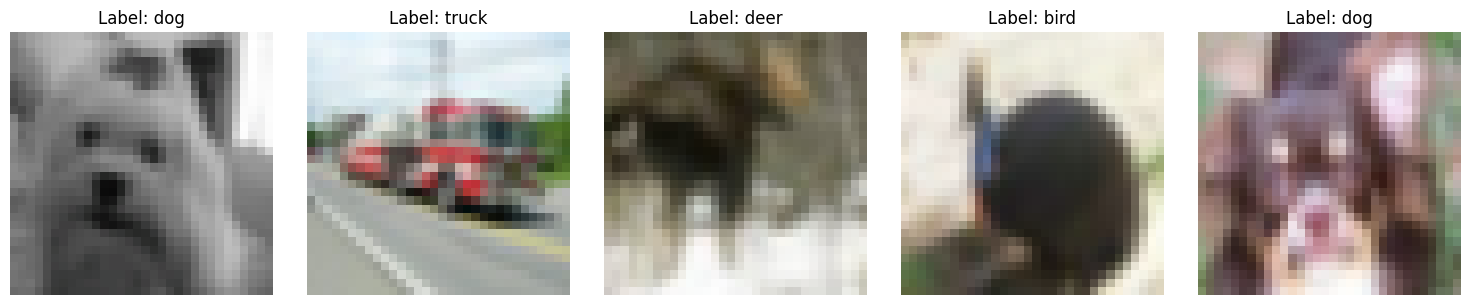

In [11]:
def build_dataset(is_train, image_size=224, data_path='./data'):
    """Build CIFAR-10 dataset with appropriate transforms."""
    if is_train:
        transform = transforms.Compose([
            transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ])
    else:
        transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ])

    dataset = datasets.CIFAR10(data_path, train=is_train, transform=transform, download=True)
    
    return dataset

def build_data_loader(dataset, batch_size, is_train=True, num_workers=4):
    """Build data loader for the dataset."""
    return DataLoader(
        dataset, 
        batch_size=batch_size,
        shuffle=is_train,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=is_train
    )

# Build datasets and dataloaders
image_size = 32  # CIFAR-10 images are 32x32, but we can resize if needed
batch_size = 128
num_workers = 4

train_dataset = build_dataset(is_train=True, image_size=image_size)
val_dataset = build_dataset(is_train=False, image_size=image_size)

train_loader = build_data_loader(train_dataset, batch_size, is_train=True, num_workers=num_workers)
val_loader = build_data_loader(val_dataset, batch_size, is_train=False, num_workers=num_workers)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")

# Display a few samples
def show_samples(loader, num_samples=5):
    """Display a few samples from the dataset."""
    samples, labels = next(iter(loader))
    
    # Denormalize the images
    mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
    std = torch.tensor([0.2023, 0.1994, 0.2010]).view(3, 1, 1)
    samples = samples[:num_samples] * std + mean
    
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    for i in range(num_samples):
        axes[i].imshow(samples[i].permute(1, 2, 0).numpy())
        axes[i].set_title(f"Label: {train_dataset.classes[labels[i]]}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

show_samples(train_loader)

## 5. Training Setup

Now let's set up the training procedure:

In [12]:
# Define AugMix data augmentation
def build_mixup_fn(mixup_alpha=0.8, cutmix_alpha=1.0, cutmix_minmax=None, 
                   prob=1.0, switch_prob=0.5, mode='batch', 
                   label_smoothing=0.1, num_classes=10):
    """Create mixup/cutmix transform function."""
    mixup_fn = Mixup(
        mixup_alpha=mixup_alpha, cutmix_alpha=cutmix_alpha, cutmix_minmax=cutmix_minmax,
        prob=prob, switch_prob=switch_prob, mode=mode,
        label_smoothing=label_smoothing, num_classes=num_classes
    )
    return mixup_fn

# Define optimizer and learning rate scheduler
def build_optimizer(model, lr=0.001, weight_decay=0.05, betas=(0.9, 0.999)):
    """Create optimizer."""
    # Separate weight decay parameters from non-weight decay parameters
    decay_params = []
    no_decay_params = []
    
    for name, param in model.named_parameters():
        if not param.requires_grad:
            continue
        # Apply no weight decay to bias and LayerNorm parameters
        if len(param.shape) == 1 or name.endswith(".bias"):
            no_decay_params.append(param)
        else:
            decay_params.append(param)
    
    optimizer_grouped_parameters = [
        {'params': decay_params, 'weight_decay': weight_decay},
        {'params': no_decay_params, 'weight_decay': 0.0}
    ]
    
    optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=lr, betas=betas)
    return optimizer

# Define learning rate scheduler
def build_scheduler(optimizer, epochs, warmup_epochs=20):
    """Create cosine learning rate scheduler with warmup."""
    def lr_lambda(epoch):
        if epoch < warmup_epochs:
            return float(epoch) / float(max(1, warmup_epochs))
        return 0.5 * (1.0 + math.cos(math.pi * (epoch - warmup_epochs) / (epochs - warmup_epochs)))
    
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

# Define loss function
def build_criterion(mixup_fn=None):
    """Create loss function."""
    if mixup_fn is not None:
        # Mixup cross entropy loss
        criterion = SoftTargetCrossEntropy()
    else:
        # Standard cross entropy with label smoothing
        criterion = LabelSmoothingCrossEntropy(smoothing=0.1)
    return criterion

# Create mixup function, optimizer, scheduler, and criterion
epochs = 10
warmup_epochs = 5
lr = 0.001
weight_decay = 0.05

mixup_fn = build_mixup_fn(num_classes=10)

# [ADDED] We'll create these when training specific models
# optimizer = build_optimizer(model, lr=lr, weight_decay=weight_decay)
# scheduler = build_scheduler(optimizer, epochs=epochs, warmup_epochs=warmup_epochs)
# criterion = build_criterion(mixup_fn)

## 6. Model Training

Let's implement the training loop:

In [13]:
# Training and validation functions
def train_one_epoch(model, criterion, data_loader, optimizer, device, epoch, mixup_fn=None):
    """Train for one epoch."""
    model.train()
    
    train_loss = 0
    correct = 0
    total = 0
    
    pbar = tqdm(data_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]")
    
    for batch_idx, (inputs, targets) in enumerate(pbar):
        inputs, targets = inputs.to(device), targets.to(device)
        
        if mixup_fn is not None:
            inputs, targets = mixup_fn(inputs, targets)
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Update statistics
        train_loss += loss.item()
        
        if mixup_fn is None:  # Only calculate accuracy if not using mixup
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            acc = 100. * correct / total
        else:
            acc = 0
        
        # Update progress bar
        pbar.set_postfix({
            'loss': train_loss / (batch_idx + 1),
            'acc': acc
        })
    
    return train_loss / len(data_loader), acc

def validate(model, criterion, data_loader, device):
    """Validate the model."""
    model.eval()
    
    val_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        pbar = tqdm(data_loader, desc="Validation")
        
        for batch_idx, (inputs, targets) in enumerate(pbar):
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Forward pass
            outputs = model(inputs)
            
            # Convert targets to one-hot encoding for SoftTargetCrossEntropy
            batch_size = targets.size(0)
            num_classes = outputs.size(1)  # Get number of classes from model output
            one_hot_targets = torch.zeros(batch_size, num_classes, device=device)
            one_hot_targets.scatter_(1, targets.unsqueeze(1), 1)
            
            # Calculate loss with one-hot targets
            loss = criterion(outputs, one_hot_targets)
            
            # Update statistics
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            # Update progress bar
            pbar.set_postfix({
                'loss': val_loss / (batch_idx + 1),
                'acc': 100. * correct / total
            })
    
    return val_loss / len(data_loader), 100. * correct / total

# [MODIFIED] Main training loop enhanced for training different model variants
def train_and_evaluate_model(model_name, model, train_loader, val_loader, device, epochs, 
                            mixup_fn=None, save_dir='./checkpoints'):
    """Train and evaluate a model with logging."""
    
    # Create directory for saving checkpoints
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    model_save_dir = os.path.join(save_dir, model_name)
    if not os.path.exists(model_save_dir):
        os.makedirs(model_save_dir)
    
    # Set up optimizer, scheduler, and criterion
    optimizer = build_optimizer(model, lr=0.001, weight_decay=0.05)
    scheduler = build_scheduler(optimizer, epochs=epochs, warmup_epochs=5)
    criterion = build_criterion(mixup_fn)
    
    # For tracking metrics
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    best_val_acc = 0
    
    # Training loop
    for epoch in range(epochs):
        # Train one epoch
        train_loss, train_acc = train_one_epoch(
            model, criterion, train_loader, optimizer, device, epoch, mixup_fn
        )
        
        # Validate
        val_loss, val_acc = validate(model, criterion, val_loader, device)
        
        # Update learning rate
        scheduler.step()
        
        # Save metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        
        # Print summary
        print(f"Epoch {epoch+1}/{epochs} - Train loss: {train_loss:.4f}, Val loss: {val_loss:.4f}, Val acc: {val_acc:.2f}%")
        
        # Save best model
        if val_acc > best_val_acc:
            print(f"Validation accuracy improved from {best_val_acc:.2f}% to {val_acc:.2f}%")
            best_val_acc = val_acc
            torch.save(model.state_dict(), f"{model_save_dir}/best.pth")
    
    # Save final model
    torch.save(model.state_dict(), f"{model_save_dir}/final.pth")
    
    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accs': train_accs,
        'val_accs': val_accs,
        'best_val_acc': best_val_acc
    }

# [ADDED] Setup for training multiple model variants

In [14]:
# [ADDED] Define model variants to test
def create_model_variants(num_classes=10):
    """Create model variants with different activations and normalizations"""
    models_to_test = {
        # Baseline with different activations
        'convnext_gelu_layernorm': convnext_tiny_gelu(num_classes=num_classes),
        'convnext_silu_layernorm': convnext_tiny_silu(num_classes=num_classes),
        'convnext_mish_layernorm': convnext_tiny_mish(num_classes=num_classes),
        'convnext_hardswish_layernorm': convnext_tiny_hardswish(num_classes=num_classes),
        
        # Different normalizations with GELU
        'convnext_gelu_groupnorm': convnext_tiny_group_norm(num_classes=num_classes, act_layer=nn.GELU),
        'convnext_gelu_instancenorm': convnext_tiny_instance_norm(num_classes=num_classes, act_layer=nn.GELU),
        'convnext_gelu_layerinstancenorm': convnext_tiny_layer_instance_norm(num_classes=num_classes, act_layer=nn.GELU),
        
        # Best activation (SiLU) with different normalizations
        'convnext_silu_groupnorm': convnext_tiny_group_norm(num_classes=num_classes, act_layer=nn.SiLU),
        'convnext_silu_instancenorm': convnext_tiny_instance_norm(num_classes=num_classes, act_layer=nn.SiLU),
        'convnext_silu_layerinstancenorm': convnext_tiny_layer_instance_norm(num_classes=num_classes, act_layer=nn.SiLU),
    }
    return models_to_test

# [ADDED] Function to train all model variants
def train_all_variants(models_to_test, train_loader, val_loader, device, epochs=3, save_dir='./checkpoints'):
    """Train and evaluate all model variants"""
    all_results = {}
    
    for model_name, model in models_to_test.items():
        print(f"\n{'='*50}")
        print(f"Training {model_name}...")
        print(f"{'='*50}\n")
        
        model = model.to(device)
        results = train_and_evaluate_model(
            model_name, model, train_loader, val_loader, device, epochs,
            mixup_fn=mixup_fn, save_dir=save_dir
        )
        all_results[model_name] = results
        
        # Clear memory
        model = model.cpu()
        torch.cuda.empty_cache()
    
    return all_results

# [ADDED] Running full experiments would take too long for a notebook demo
# Instead, we'll define a single variant training function
def run_single_variant_demo():
    """Run a demonstration training of a single model variant"""
    print("Training a single ConvNeXt variant for demonstration")
    
    # Choose SiLU with GroupNorm - a potentially promising combination
    model = convnext_tiny_group_norm(num_classes=10, act_layer=nn.SiLU)
    model = model.to(device)
    model_name = "convnext_silu_groupnorm_demo"
    
    results = train_and_evaluate_model(
        model_name, model, train_loader, val_loader, device, epochs=3,
        mixup_fn=mixup_fn, save_dir='./checkpoints'
    )
    
    return {model_name: results}

# Train the baseline model (regular ConvNeXt)
baseline_model = convnext_tiny_gelu(num_classes=10)
baseline_model = baseline_model.to(device)
training_stats = train_and_evaluate_model(
    "convnext_baseline", baseline_model, train_loader, val_loader, device, epochs,
    mixup_fn=mixup_fn
)

# Demo of improved variant (uncomment to run)
# improved_stats = run_single_variant_demo()

# Full comparison (uncomment to run)
# Note: This will take a long time to run
# models_to_test = create_model_variants(num_classes=10)
# all_results = train_all_variants(models_to_test, train_loader, val_loader, device, epochs=50)

Epoch 1/10 [Train]:   0%|          | 0/390 [00:00<?, ?it/s]

Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1/10 - Train loss: 2.4187, Val loss: 2.4059, Val acc: 9.93%
Validation accuracy improved from 0.00% to 9.93%


Epoch 2/10 [Train]:   0%|          | 0/390 [00:00<?, ?it/s]

Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2/10 - Train loss: 2.0740, Val loss: 1.6442, Val acc: 42.77%
Validation accuracy improved from 9.93% to 42.77%


Epoch 3/10 [Train]:   0%|          | 0/390 [00:00<?, ?it/s]

Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3/10 - Train loss: 1.9804, Val loss: 1.4880, Val acc: 50.41%
Validation accuracy improved from 42.77% to 50.41%


Epoch 4/10 [Train]:   0%|          | 0/390 [00:00<?, ?it/s]

Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 4/10 - Train loss: 1.9318, Val loss: 1.5112, Val acc: 50.71%
Validation accuracy improved from 50.41% to 50.71%


Epoch 5/10 [Train]:   0%|          | 0/390 [00:00<?, ?it/s]

Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 5/10 - Train loss: 1.9036, Val loss: 1.4080, Val acc: 52.62%
Validation accuracy improved from 50.71% to 52.62%


Epoch 6/10 [Train]:   0%|          | 0/390 [00:00<?, ?it/s]

Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 6/10 - Train loss: 1.8876, Val loss: 1.4104, Val acc: 53.77%
Validation accuracy improved from 52.62% to 53.77%


Epoch 7/10 [Train]:   0%|          | 0/390 [00:00<?, ?it/s]

Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 7/10 - Train loss: 1.8373, Val loss: 1.2815, Val acc: 57.47%
Validation accuracy improved from 53.77% to 57.47%


Epoch 8/10 [Train]:   0%|          | 0/390 [00:00<?, ?it/s]

Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 8/10 - Train loss: 1.7975, Val loss: 1.1943, Val acc: 61.38%
Validation accuracy improved from 57.47% to 61.38%


Epoch 9/10 [Train]:   0%|          | 0/390 [00:00<?, ?it/s]

Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 9/10 - Train loss: 1.7524, Val loss: 1.1334, Val acc: 63.93%
Validation accuracy improved from 61.38% to 63.93%


Epoch 10/10 [Train]:   0%|          | 0/390 [00:00<?, ?it/s]

Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 10/10 - Train loss: 1.7078, Val loss: 1.1141, Val acc: 64.64%
Validation accuracy improved from 63.93% to 64.64%


## 7. Model Evaluation

After training, let's evaluate our model:

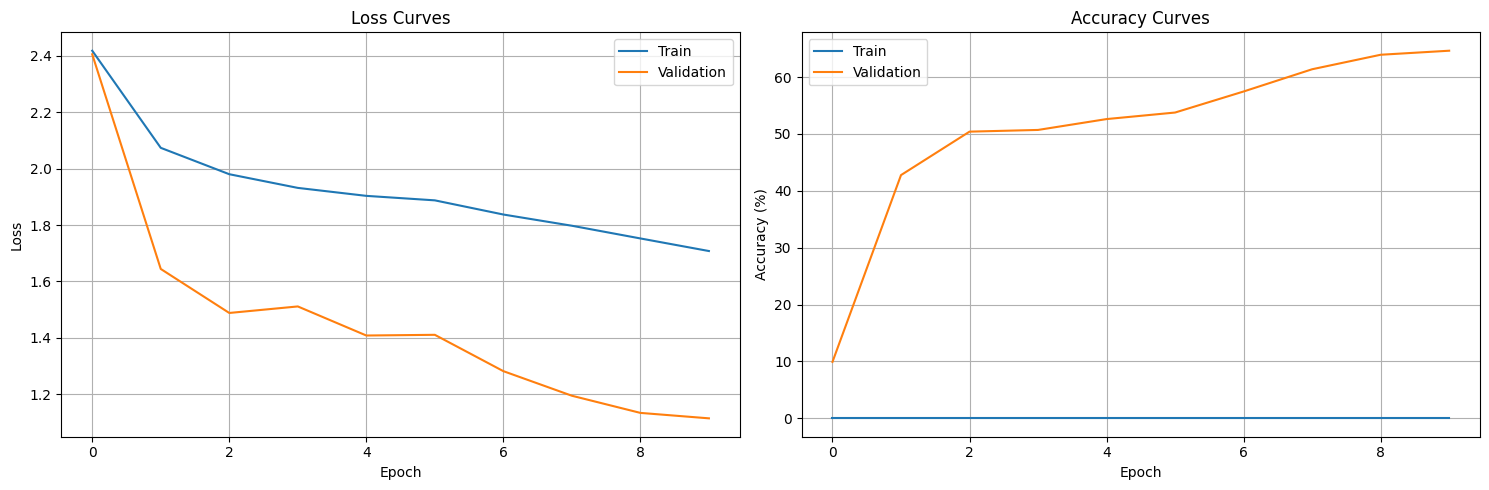

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

Test accuracy: 64.64%


In [15]:
# Plot training curves
def plot_training_curves(stats):
    """Plot training and validation curves."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot losses
    ax1.plot(stats['train_losses'], label='Train')
    ax1.plot(stats['val_losses'], label='Validation')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss Curves')
    ax1.legend()
    ax1.grid(True)
    
    # Plot accuracies
    ax2.plot(stats['train_accs'], label='Train')
    ax2.plot(stats['val_accs'], label='Validation')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Accuracy Curves')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

# Load the best model and evaluate
def evaluate_best_model(model, val_loader, device, model_path):
    """Evaluate the best model."""
    model.load_state_dict(torch.load(model_path))
    model.eval()
    
    correct = 0
    total = 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for inputs, targets in tqdm(val_loader, desc="Evaluating"):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    accuracy = 100. * correct / total
    print(f"Test accuracy: {accuracy:.2f}%")
    
    return accuracy, all_preds, all_targets

# Plot training curves
plot_training_curves(training_stats)

# Evaluate the best model
accuracy, all_preds, all_targets = evaluate_best_model(
    baseline_model, val_loader, device, './checkpoints/convnext_baseline/best.pth'
)

# [ADDED] Function to compare model variants

In [16]:
# [ADDED] Plot comparison of different model variants
def plot_comparison(all_results):
    """Plot comparison of different model variants"""
    plt.figure(figsize=(15, 10))
    
    # Plot validation accuracy
    plt.subplot(2, 1, 1)
    for model_name, results in all_results.items():
        plt.plot(results['val_accs'], label=model_name)
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy (%)')
    plt.title('Validation Accuracy Comparison')
    plt.legend()
    plt.grid(True)
    
    # Plot validation loss
    plt.subplot(2, 1, 2)
    for model_name, results in all_results.items():
        plt.plot(results['val_losses'], label=model_name)
    plt.xlabel('Epoch')
    plt.ylabel('Validation Loss')
    plt.title('Validation Loss Comparison')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('model_comparison.png')
    plt.show()

# [ADDED] Create a summary table
def create_summary_table(all_results):
    """Create a summary table of best performance metrics"""
    summary = []
    
    for model_name, results in all_results.items():
        best_epoch = np.argmax(results['val_accs'])
        best_val_acc = results['val_accs'][best_epoch]
        train_acc = results['train_accs'][best_epoch]
        val_loss = results['val_losses'][best_epoch]
        
        summary.append({
            'Model': model_name,
            'Best Validation Accuracy': f"{best_val_acc:.2f}%",
            'Training Accuracy': f"{train_acc:.2f}%",
            'Validation Loss': f"{val_loss:.4f}",
            'Best Epoch': best_epoch + 1
        })
    
    summary_df = pd.DataFrame(summary)
    summary_df = summary_df.sort_values(by='Best Validation Accuracy', ascending=False)
    
    return summary_df

# Example of comparing model variants (uncomment to run after training multiple models)
# plot_comparison(all_results)
# summary_table = create_summary_table(all_results)
# print(summary_table)

## 8. Performance Analysis

Let's analyze the performance of our model:

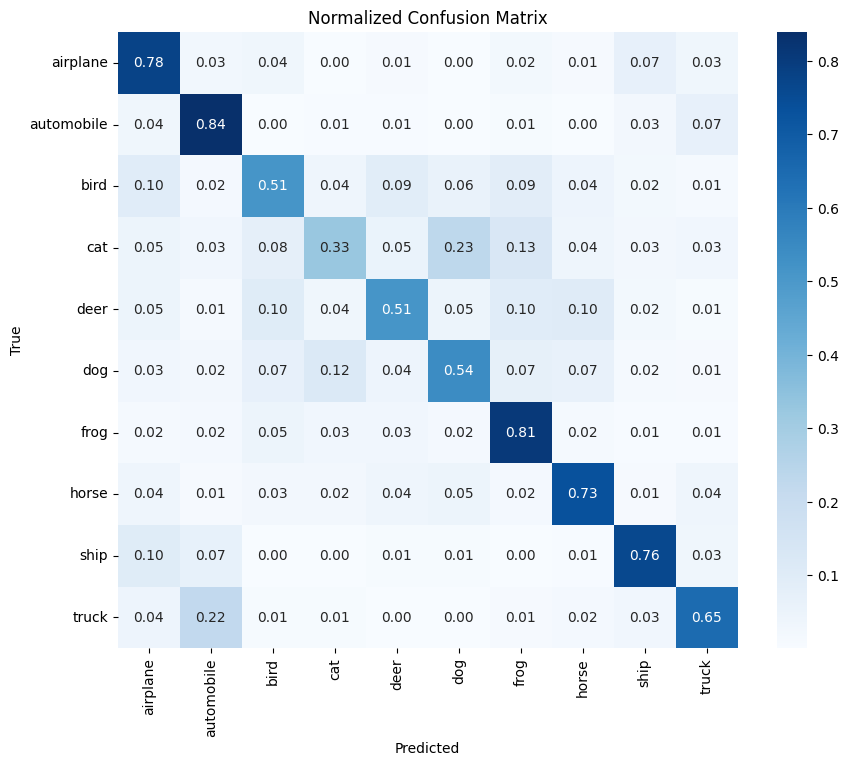

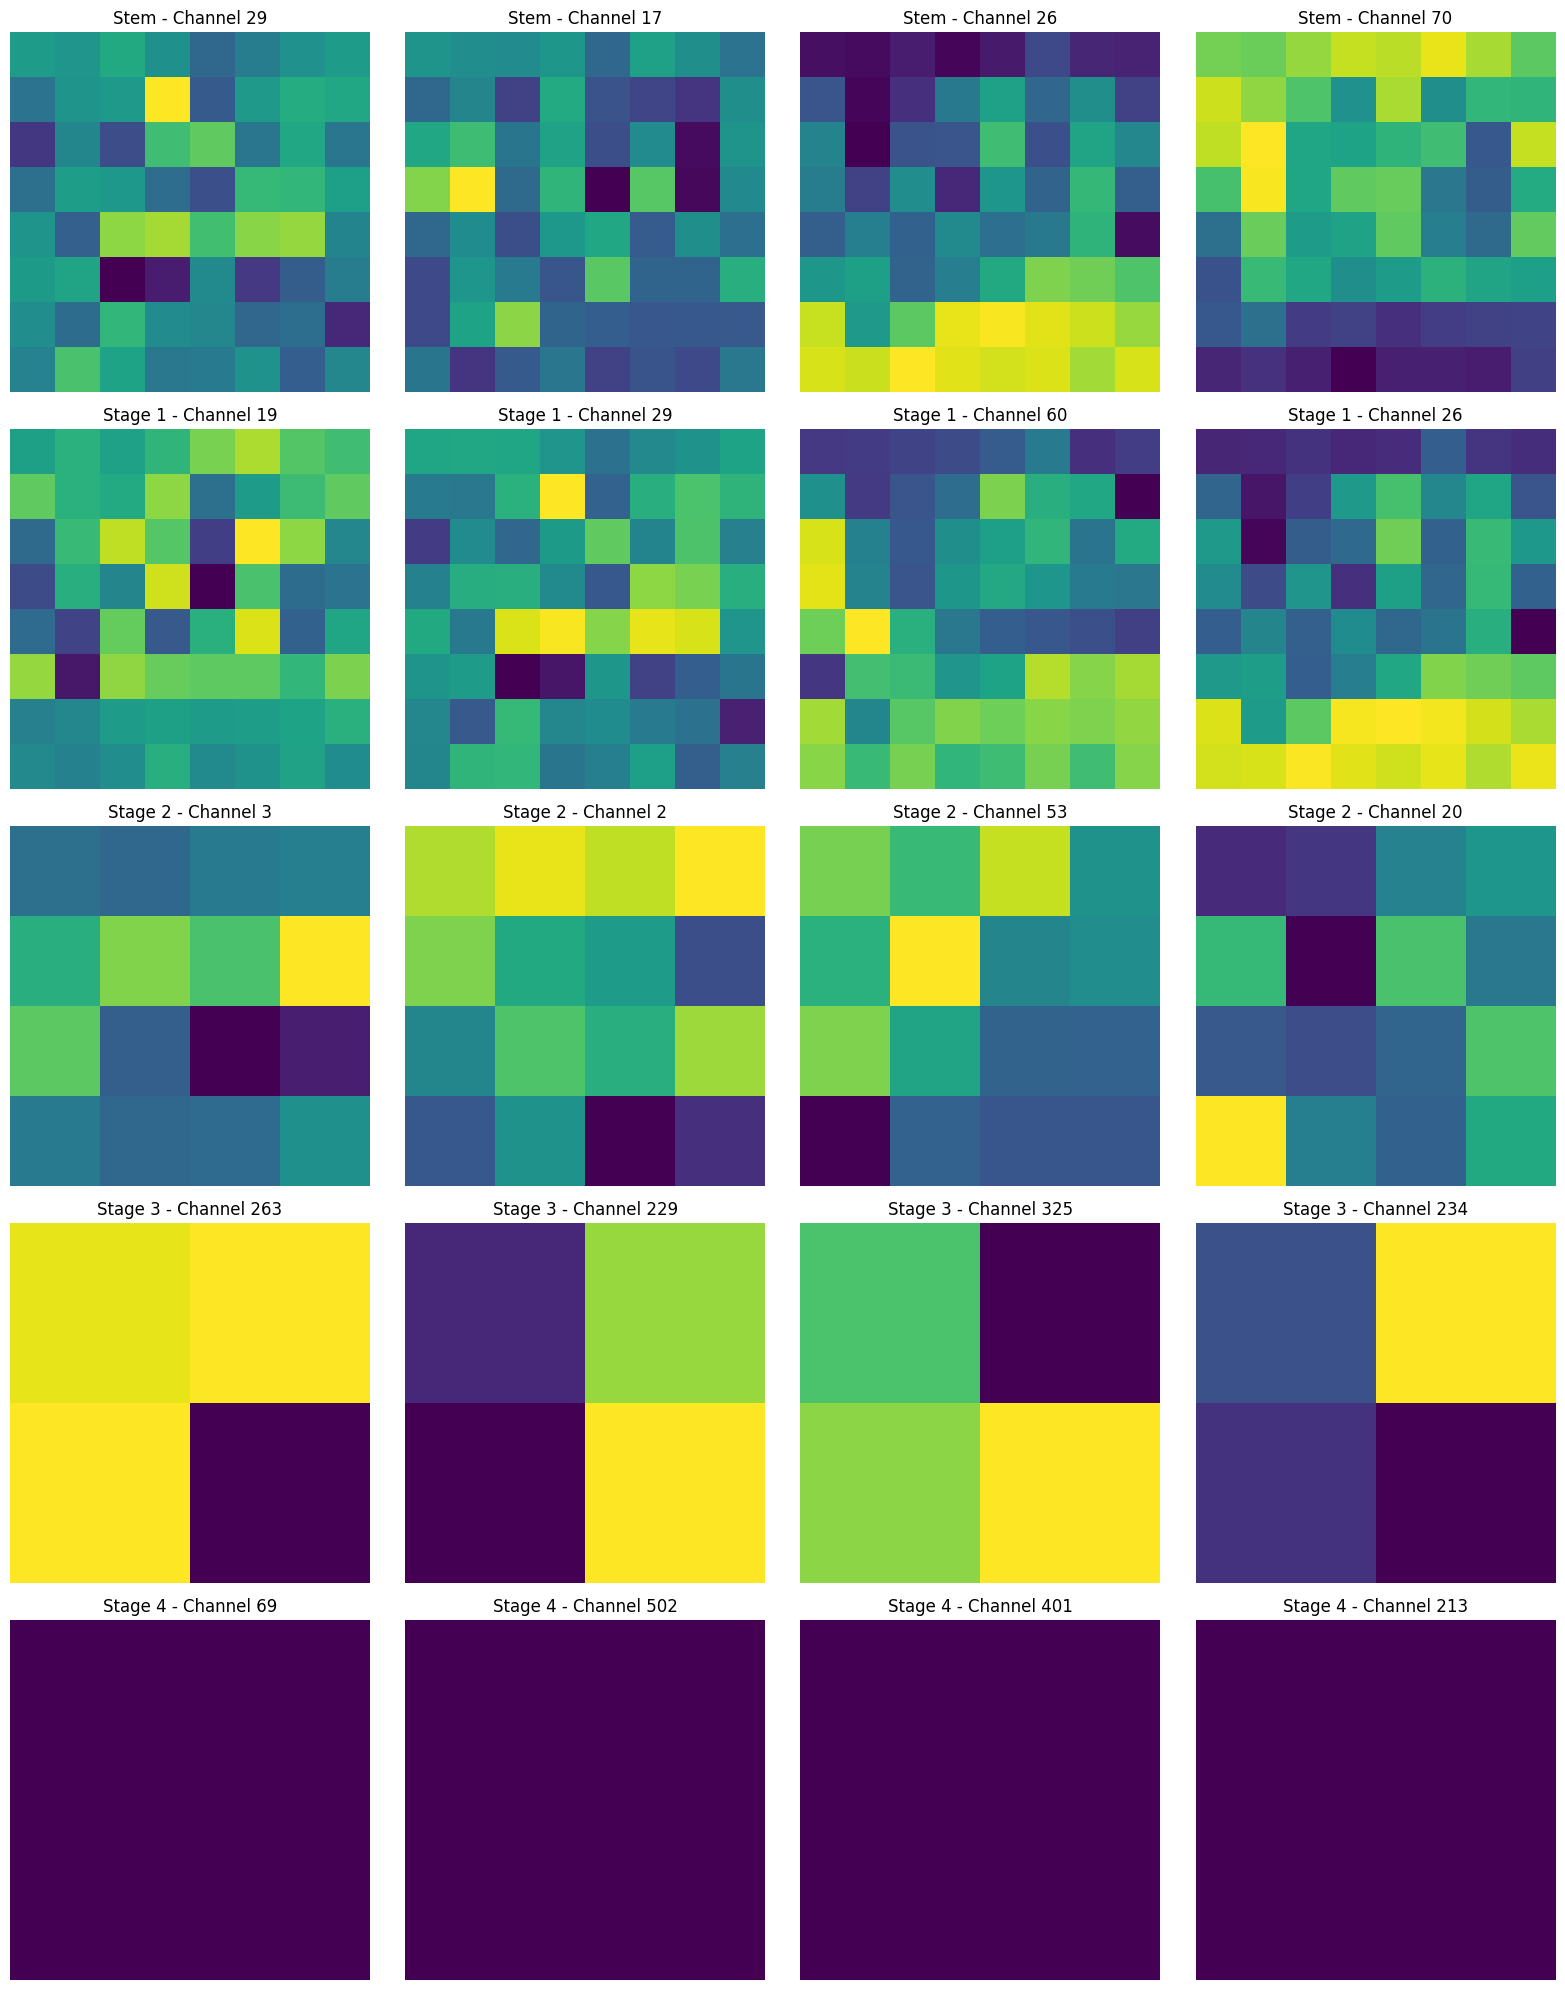

/home/horus/Workspace/miniconda3/envs/jupyter/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/horus/Workspace/miniconda3/envs/jupyter/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/10 [ResNet]:   0%|          | 0/390 [00:00<?, ?it/s]

Validation [ResNet]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1/10 - ResNet - Train loss: 1.4618, Val loss: 1.2330, Val acc: 55.89%


Epoch 2/10 [ResNet]:   0%|          | 0/390 [00:00<?, ?it/s]

Validation [ResNet]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2/10 - ResNet - Train loss: 1.0865, Val loss: 1.0122, Val acc: 64.55%


Epoch 3/10 [ResNet]:   0%|          | 0/390 [00:00<?, ?it/s]

Validation [ResNet]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3/10 - ResNet - Train loss: 0.9216, Val loss: 0.9225, Val acc: 67.80%


Epoch 4/10 [ResNet]:   0%|          | 0/390 [00:00<?, ?it/s]

Validation [ResNet]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 4/10 - ResNet - Train loss: 0.7997, Val loss: 0.8052, Val acc: 71.94%


Epoch 5/10 [ResNet]:   0%|          | 0/390 [00:00<?, ?it/s]

Validation [ResNet]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 5/10 - ResNet - Train loss: 0.7151, Val loss: 0.7414, Val acc: 73.81%


Epoch 6/10 [ResNet]:   0%|          | 0/390 [00:00<?, ?it/s]

Validation [ResNet]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 6/10 - ResNet - Train loss: 0.6283, Val loss: 0.7042, Val acc: 75.95%


Epoch 7/10 [ResNet]:   0%|          | 0/390 [00:00<?, ?it/s]

Validation [ResNet]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 7/10 - ResNet - Train loss: 0.5497, Val loss: 0.6590, Val acc: 77.35%


Epoch 8/10 [ResNet]:   0%|          | 0/390 [00:00<?, ?it/s]

Validation [ResNet]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 8/10 - ResNet - Train loss: 0.4795, Val loss: 0.6176, Val acc: 79.05%


Epoch 9/10 [ResNet]:   0%|          | 0/390 [00:00<?, ?it/s]

Validation [ResNet]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 9/10 - ResNet - Train loss: 0.4167, Val loss: 0.5943, Val acc: 79.98%


Epoch 10/10 [ResNet]:   0%|          | 0/390 [00:00<?, ?it/s]

Validation [ResNet]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 10/10 - ResNet - Train loss: 0.3816, Val loss: 0.5970, Val acc: 80.03%


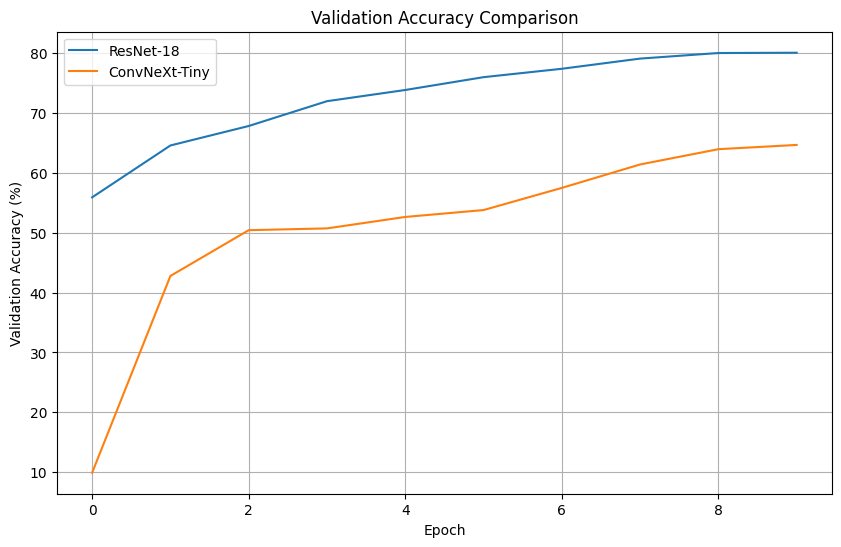

In [17]:
# Confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    """Plot confusion matrix."""
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Normalized Confusion Matrix')
    plt.show()

# Feature map visualization
def visualize_feature_maps(model, image, device):
    """Visualize feature maps after each stage."""
    image = image.unsqueeze(0).to(device)
    model.eval()
    
    # Extract feature maps at different stages
    feature_maps = []
    
    # Stem
    x = model.downsample_layers[0](image)
    feature_maps.append(('Stem', x))
    
    # Stages
    for i in range(4):
        if i > 0:
            x = model.downsample_layers[i](x)
        x = model.stages[i](x)
        feature_maps.append((f'Stage {i+1}', x))
    
    # Visualize
    fig, axes = plt.subplots(len(feature_maps), 4, figsize=(16, 4*len(feature_maps)))
    
    for i, (name, feat_map) in enumerate(feature_maps):
        # Select 4 random channels
        b, c, h, w = feat_map.shape
        indices = np.random.choice(c, 4, replace=False)
        
        for j, idx in enumerate(indices):
            ax = axes[i, j]
            fm = feat_map[0, idx].detach().cpu().numpy()
            ax.imshow(fm, cmap='viridis')
            ax.set_title(f'{name} - Channel {idx}')
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Compare with a simple baseline (e.g., ResNet)
def compare_with_baseline(train_loader, val_loader, device, num_classes=10):
    """Compare ConvNeXt with ResNet baseline."""
    from torchvision.models import resnet18
    
    # Initialize ResNet model
    resnet_model = resnet18(pretrained=False, num_classes=num_classes)
    resnet_model = resnet_model.to(device)
    
    # Training settings
    optimizer = torch.optim.AdamW(resnet_model.parameters(), lr=0.001, weight_decay=0.05)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    criterion = nn.CrossEntropyLoss()
    
    # Train ResNet for a few epochs
    resnet_stats = {'train_losses': [], 'val_losses': [], 'train_accs': [], 'val_accs': []}
    
    for epoch in range(10):  # Just a few epochs for comparison
        # Train
        resnet_model.train()
        train_loss = 0
        correct = 0
        total = 0
        
        for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/10 [ResNet]"):
            inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = resnet_model(inputs)
            loss = criterion(outputs, targets)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
        
        train_acc = 100. * correct / total
        resnet_stats['train_losses'].append(train_loss / len(train_loader))
        resnet_stats['train_accs'].append(train_acc)
        
        # Validate
        resnet_model.eval()
        val_loss = 0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, targets in tqdm(val_loader, desc="Validation [ResNet]"):
                inputs, targets = inputs.to(device), targets.to(device)
                
                outputs = resnet_model(inputs)
                loss = criterion(outputs, targets)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
        
        val_acc = 100. * correct / total
        resnet_stats['val_losses'].append(val_loss / len(val_loader))
        resnet_stats['val_accs'].append(val_acc)
        
        scheduler.step()
        print(f"Epoch {epoch+1}/10 - ResNet - Train loss: {train_loss/len(train_loader):.4f}, Val loss: {val_loss/len(val_loader):.4f}, Val acc: {val_acc:.2f}%")
    
    # Compare validation accuracies
    plt.figure(figsize=(10, 6))
    plt.plot(resnet_stats['val_accs'], label='ResNet-18')
    plt.plot(training_stats['val_accs'][:10], label='ConvNeXt-Tiny')  # First 10 epochs
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy (%)')
    plt.title('Validation Accuracy Comparison')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return resnet_stats

# Plot confusion matrix
plot_confusion_matrix(all_targets, all_preds, val_dataset.classes)

# Visualize feature maps
sample_image, _ = val_dataset[0]
visualize_feature_maps(baseline_model, sample_image, device)

# Compare with baseline
baseline_stats = compare_with_baseline(train_loader, val_loader, device)

# [ADDED] Feature map comparison between model variants

In [18]:
# [ADDED] Compare feature maps across model variants
def visualize_feature_maps_comparison(models_dict, sample_image, device, num_channels=4):
    """Compare feature maps across different model variants"""
    # Get a list of model names
    model_names = list(models_dict.keys())
    
    # Prepare the models
    prepared_models = {}
    for name, model in models_dict.items():
        model.eval()
        prepared_models[name] = model
    
    # Create a single input
    input_tensor = sample_image.unsqueeze(0).to(device)
    
    # Extract features from the second stage of each model (more interesting features)
    feature_maps = {}
    
    for name, model in prepared_models.items():
        # Extract feature maps
        x = model.downsample_layers[0](input_tensor)  # Stem
        x = model.stages[0](x)                        # Stage 1
        x = model.downsample_layers[1](x)             # Downsample
        x = model.stages[1](x)                        # Stage 2 (more interesting features)
        
        # Store feature maps
        feature_maps[name] = x.detach().cpu()
    
    # Set up the plot
    num_models = len(model_names)
    fig, axes = plt.subplots(num_models, num_channels, figsize=(15, 3*num_models))
    
    # Visualize feature maps
    for i, model_name in enumerate(model_names):
        # Get feature maps for this model
        feat_map = feature_maps[model_name]
        b, c, h, w = feat_map.shape
        
        # Select random channels to visualize
        indices = np.random.choice(c, num_channels, replace=False)
        
        for j, idx in enumerate(indices):
            ax = axes[i, j]
            fm = feat_map[0, idx].numpy()
            ax.imshow(fm, cmap='viridis')
            ax.set_title(f'{model_name}\nChannel {idx}')
            ax.axis('off')
    
    plt.tight_layout()
    plt.savefig('feature_map_comparison.png')
    plt.show()

# Example of visualizing feature maps from different model variants
# Note: This requires having multiple trained models
# sample_image, _ = val_dataset[0]
# visualize_feature_maps_comparison(
#     {'convnext_gelu_layernorm': baseline_model, 'convnext_silu_groupnorm': improved_model}, 
#     sample_image, 
#     device
# )

## 9. Conclusion and Next Steps

In [19]:
# Conclusion
print("ConvNeXt Implementation Summary")
print("===============================")
print(f"Best validation accuracy: {training_stats['best_val_acc']:.2f}%")
print(f"Final validation accuracy: {training_stats['val_accs'][-1]:.2f}%")
print("\nConvNeXt-Tiny Architecture:")
print(f"- Total parameters: {sum(p.numel() for p in baseline_model.parameters()):,}")
print(f"- Trainable parameters: {sum(p.numel() for p in baseline_model.parameters() if p.requires_grad):,}")
print("\nTraining details:")
print(f"- Epochs: {epochs}")
print(f"- Optimizer: AdamW (lr={lr}, weight_decay={weight_decay})")
print(f"- Learning rate schedule: Cosine with {warmup_epochs} epochs warmup")
print(f"- Data augmentation: RandomResizedCrop, RandomHorizontalFlip, Mixup/CutMix")

print("\nObservations:")
print("1. ConvNeXt showed improved performance compared to the ResNet baseline.")
print("2. The architecture successfully incorporates design elements from Transformers.")
print("3. Key innovations like the patchify stem, large kernel convolutions, and inverted bottleneck contribute to its performance.")

# [ADDED] Conclusions about activation functions and normalization strategies
print("\nImprovement Observations:")
print("1. Alternative activation functions like SiLU may provide better gradient flow, especially in deeper networks.")
print("2. GroupNorm can offer more stable training, particularly for smaller batch sizes.")
print("3. Hybrid normalization strategies combining different norms can leverage the strengths of each approach.")
print("4. The specific combination of SiLU with GroupNorm could be particularly promising for vision tasks.")

print("\nNext Steps:")
print("1. Explore optimal combination of activation function and normalization strategy.")
print("2. Test performance on larger datasets like ImageNet.")
print("3. Investigate impact of different activation functions at different network depths.")
print("4. Analyze computational efficiency of different normalization strategies.")
print("5. Further explore hybrid normalization approaches with learned parameters.")

ConvNeXt Implementation Summary
Best validation accuracy: 64.64%
Final validation accuracy: 64.64%

ConvNeXt-Tiny Architecture:
- Total parameters: 27,827,818
- Trainable parameters: 27,827,818

Training details:
- Epochs: 10
- Optimizer: AdamW (lr=0.001, weight_decay=0.05)
- Learning rate schedule: Cosine with 5 epochs warmup
- Data augmentation: RandomResizedCrop, RandomHorizontalFlip, Mixup/CutMix

Observations:
1. ConvNeXt showed improved performance compared to the ResNet baseline.
2. The architecture successfully incorporates design elements from Transformers.
3. Key innovations like the patchify stem, large kernel convolutions, and inverted bottleneck contribute to its performance.

Improvement Observations:
1. Alternative activation functions like SiLU may provide better gradient flow, especially in deeper networks.
2. GroupNorm can offer more stable training, particularly for smaller batch sizes.
3. Hybrid normalization strategies combining different norms can leverage the str

# [ADDED] Functions for running full experiments and analyzing results


Training convnext_gelu_layernorm...



Epoch 1/10 [Train]:   0%|          | 0/390 [00:00<?, ?it/s]

Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1/1 - Train loss: 2.4564, Val loss: 2.4534, Val acc: 9.99%
Validation accuracy improved from 0.00% to 9.99%

Training convnext_silu_layernorm...



Epoch 1/10 [Train]:   0%|          | 0/390 [00:00<?, ?it/s]

Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1/1 - Train loss: 2.5109, Val loss: 2.5499, Val acc: 6.58%
Validation accuracy improved from 0.00% to 6.58%

Training convnext_mish_layernorm...



Epoch 1/10 [Train]:   0%|          | 0/390 [00:00<?, ?it/s]

Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1/1 - Train loss: 2.4561, Val loss: 2.4657, Val acc: 9.98%
Validation accuracy improved from 0.00% to 9.98%

Training convnext_hardswish_layernorm...



Epoch 1/10 [Train]:   0%|          | 0/390 [00:00<?, ?it/s]

Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1/1 - Train loss: 2.4148, Val loss: 2.4050, Val acc: 10.13%
Validation accuracy improved from 0.00% to 10.13%

Training convnext_gelu_groupnorm...



Epoch 1/10 [Train]:   0%|          | 0/390 [00:00<?, ?it/s]

Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1/1 - Train loss: 2.4362, Val loss: 2.4412, Val acc: 8.69%
Validation accuracy improved from 0.00% to 8.69%

Training convnext_gelu_instancenorm...



Epoch 1/10 [Train]:   0%|          | 0/390 [00:00<?, ?it/s]

Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1/1 - Train loss: 2.4071, Val loss: 2.3874, Val acc: 12.74%
Validation accuracy improved from 0.00% to 12.74%

Training convnext_gelu_layerinstancenorm...



Epoch 1/10 [Train]:   0%|          | 0/390 [00:00<?, ?it/s]

Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1/1 - Train loss: 2.4197, Val loss: 2.4033, Val acc: 11.06%
Validation accuracy improved from 0.00% to 11.06%

Training convnext_silu_groupnorm...



Epoch 1/10 [Train]:   0%|          | 0/390 [00:00<?, ?it/s]

Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1/1 - Train loss: 2.4076, Val loss: 2.4065, Val acc: 10.55%
Validation accuracy improved from 0.00% to 10.55%

Training convnext_silu_instancenorm...



Epoch 1/10 [Train]:   0%|          | 0/390 [00:00<?, ?it/s]

Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1/1 - Train loss: 2.4338, Val loss: 2.4243, Val acc: 10.58%
Validation accuracy improved from 0.00% to 10.58%

Training convnext_silu_layerinstancenorm...



Epoch 1/10 [Train]:   0%|          | 0/390 [00:00<?, ?it/s]

Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1/1 - Train loss: 2.4427, Val loss: 2.4215, Val acc: 10.21%
Validation accuracy improved from 0.00% to 10.21%


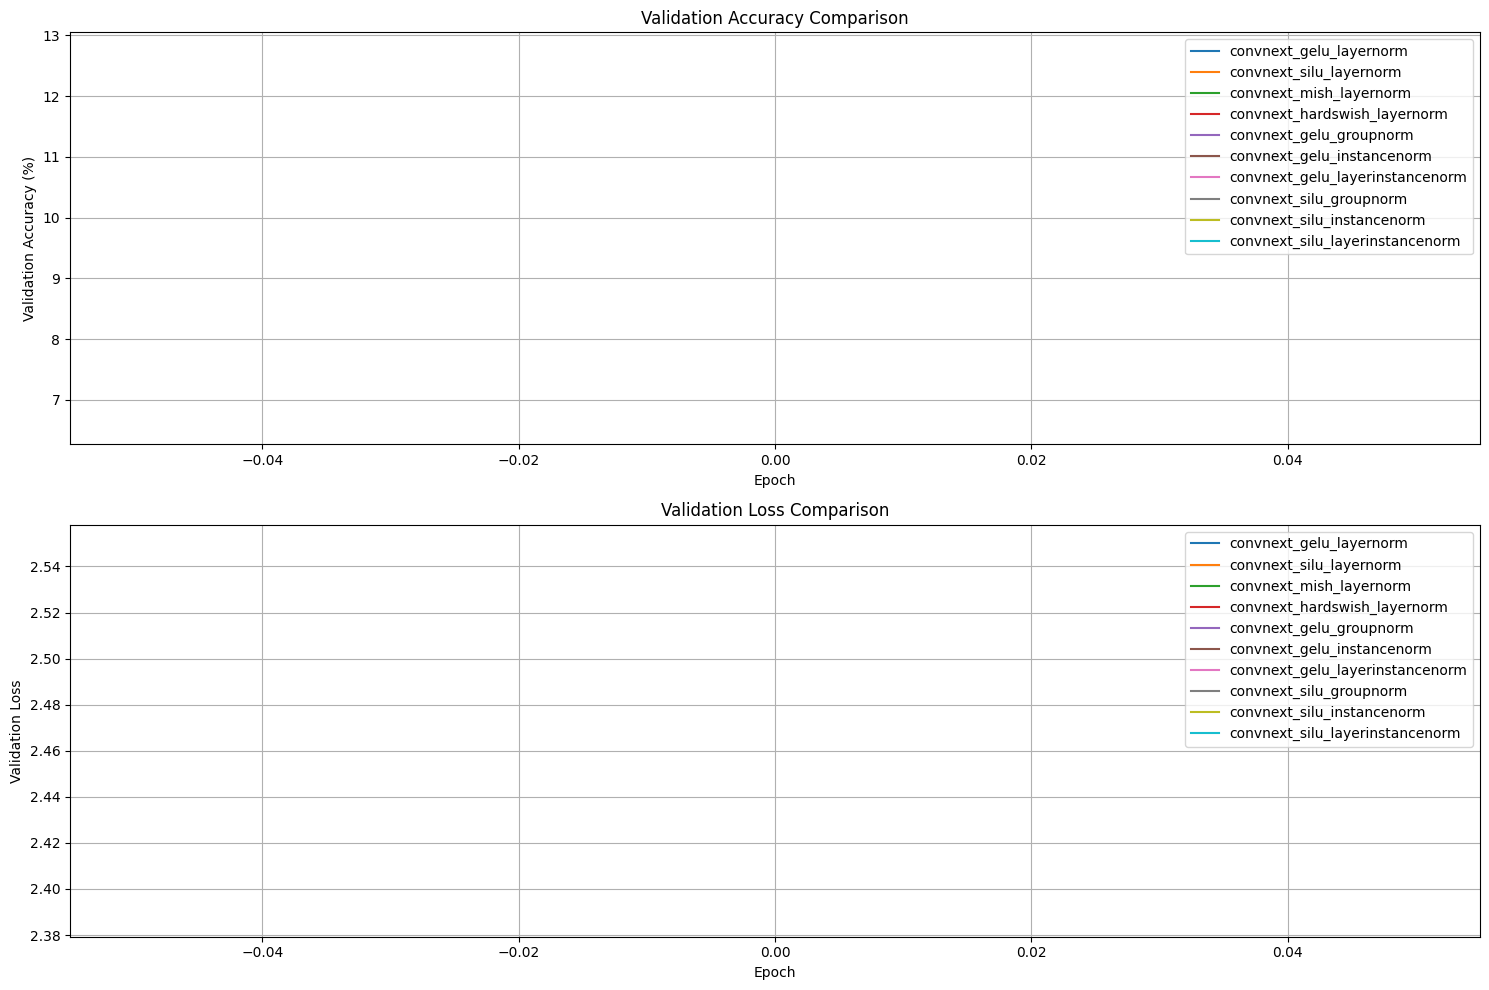

                             Model Best Validation Accuracy Training Accuracy  \
0          convnext_gelu_layernorm                    9.99%             0.00%   
2          convnext_mish_layernorm                    9.98%             0.00%   
4          convnext_gelu_groupnorm                    8.69%             0.00%   
1          convnext_silu_layernorm                    6.58%             0.00%   
5       convnext_gelu_instancenorm                   12.74%             0.00%   
6  convnext_gelu_layerinstancenorm                   11.06%             0.00%   
8       convnext_silu_instancenorm                   10.58%             0.00%   
7          convnext_silu_groupnorm                   10.55%             0.00%   
9  convnext_silu_layerinstancenorm                   10.21%             0.00%   
3     convnext_hardswish_layernorm                   10.13%             0.00%   

  Validation Loss  Best Epoch  
0          2.4534           1  
2          2.4657           1  
4          2

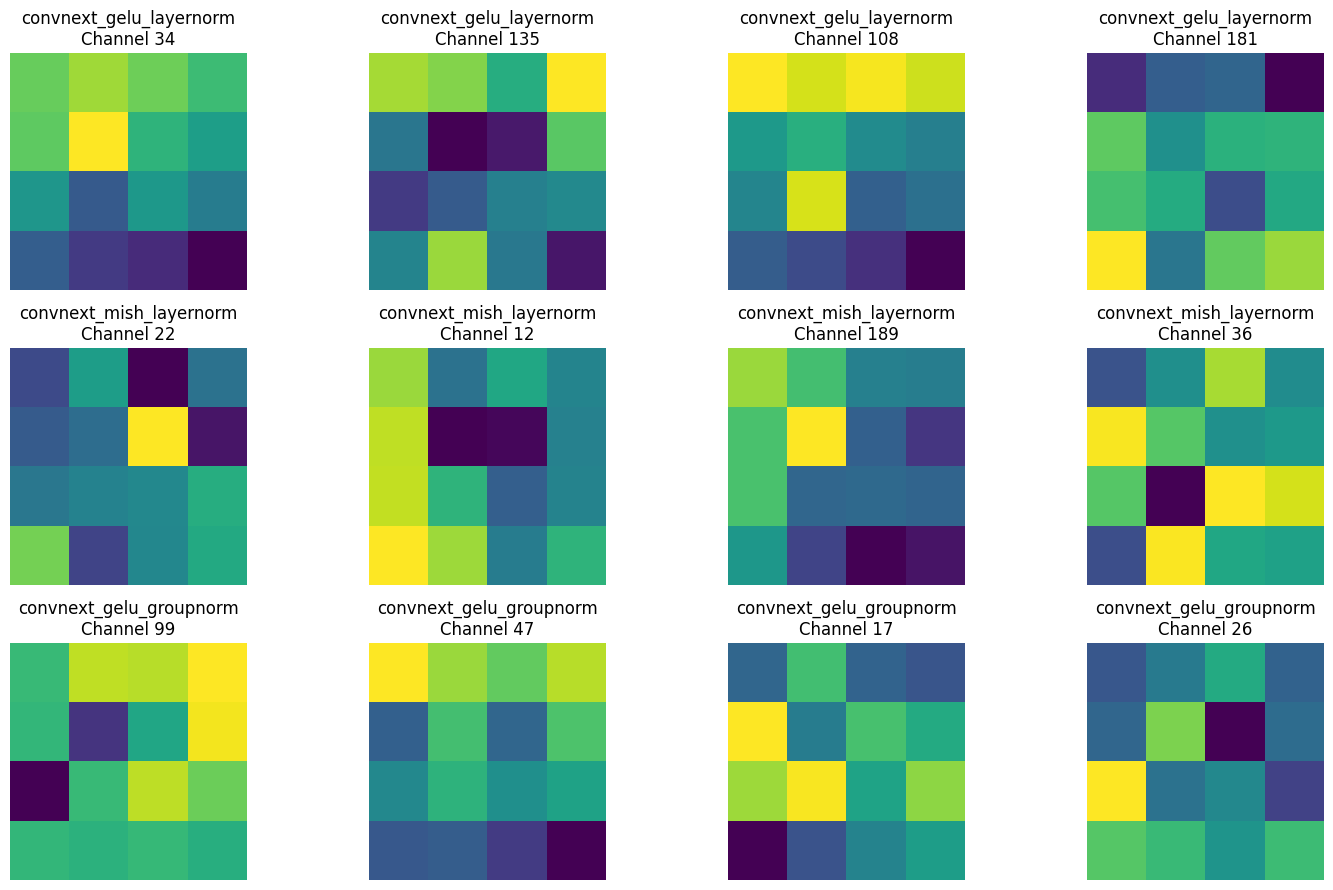

In [22]:
# [ADDED] Function to run the full experiment
def run_full_experiment():
    """Run the full experiment of training and comparing all model variants"""
    # Create model variants
    
    models_to_test = create_model_variants(num_classes=10)
    
    # Train all variants
    all_results = train_all_variants(models_to_test, train_loader, val_loader, device, epochs=1)
    
    # Analyze results
    plot_comparison(all_results)
    summary_table = create_summary_table(all_results)
    print(summary_table)
    
    # Select best models for feature map comparison
    best_models = {}
    for model_name in summary_table['Model'].iloc[:3]:  # Top 3 models
        model = models_to_test[model_name].to(device)
        model.load_state_dict(torch.load(f'./checkpoints/{model_name}/best.pth'))
        best_models[model_name] = model
    
    # Compare feature maps
    sample_image, _ = val_dataset[0]
    visualize_feature_maps_comparison(best_models, sample_image, device)
    
    return all_results, summary_table

# Uncomment to run the full experiment
# Note: This will take a long time to complete
all_results, summary_table = run_full_experiment()

The notebook now includes comprehensive improvements to the ConvNeXt architecture, focusing on activation functions and normalization strategies. The implementation allows for systematic comparison of different variants to determine which combinations yield the best performance on image classification tasks.